# Setup

In [98]:
library(tidyverse)
library(caret)

library(ranger)
library(ropls)

In [40]:
source("~/src/JupyterRReuse/VisualizationUtils.R")
source("ggcorplot.R")

[1] "Loading module to 'visutil' and 'vu' (commit: 99fb5453f2040020357d7646e80c2274e9716606)"



Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



ERROR: Error: Attempted to create layer with no stat.


In [6]:
pre_cols <- c("nr", "RI")
stone_cols <- c("Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe")
post_cols <- c("Type")
all_cols <- c(pre_cols, stone_cols, post_cols)

wide_stones_df <- read_csv("glass.data", col_names = all_cols)
head(wide_stones_df)
dim(wide_stones_df)

Parsed with column specification:
cols(
  nr = col_integer(),
  RI = col_double(),
  Na = col_double(),
  Mg = col_double(),
  Al = col_double(),
  Si = col_double(),
  K = col_double(),
  Ca = col_double(),
  Ba = col_double(),
  Fe = col_double(),
  Type = col_integer()
)


nr,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


[1] 214  11

In [7]:
long_stones_df <- wide_stones_df %>% select(stone_cols) %>% gather()
head(long_stones_df, 5)

key,value
Na,13.64
Na,13.89
Na,13.53
Na,13.21
Na,13.27


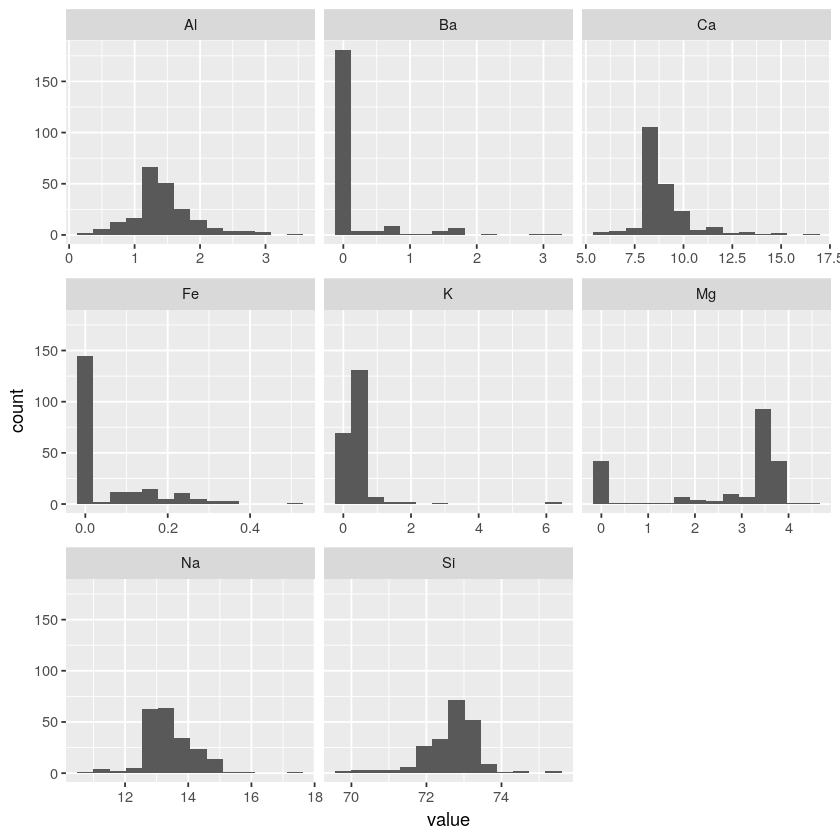

In [8]:
ggplot(long_stones_df, aes(value)) + geom_histogram(bins=14) + facet_wrap(~key, scales='free_x')

# Variable screening

Check:

* How much correlation do we have?
* What is relative importances of variables?

### Correlation

Some relatively high positive and negative correlations.

In [10]:
cor_mat <- cor(wide_stones_df %>% select(stone_cols))
cor_mat

,Na,Mg,Al,Si,K,Ca,Ba,Fe
Na,1.00000000,-0.273731961,0.15679367,-0.06980881,-0.266086504,-0.2754425,0.32660288,-0.241346411
Mg,-0.27373196,1.000000000,-0.48179851,-0.16592672,0.005395667,-0.4437500,-0.49226212,0.083059529
Al,0.15679367,-0.481798509,1.00000000,-0.00552372,0.325958446,-0.2595920,0.47940390,-0.074402151
Si,-0.06980881,-0.165926723,-0.00552372,1.00000000,-0.193330854,-0.2087322,-0.10215131,-0.094200731
K,-0.26608650,0.005395667,0.32595845,-0.19333085,1.000000000,-0.3178362,-0.04261806,-0.007719049
Ca,-0.27544249,-0.443750026,-0.25959201,-0.20873215,-0.317836155,1.0000000,-0.11284097,0.124968219
Ba,0.32660288,-0.492262118,0.47940390,-0.10215131,-0.042618059,-0.1128410,1.00000000,-0.058691755
Fe,-0.24134641,0.083059529,-0.07440215,-0.09420073,-0.007719049,0.1249682,-0.05869176,1.000000000


In [49]:
?Deducer::ggcorplot

ggcorplot {Deducer},R Documentation
cor.mat,a cor.matrix object to plot
data,the data.frame used to compute the correlation matrix
lines,Logical. Should regression lines be drawn.
type,"type of plot. ""points"" or ""bins"""
line.method,Character. Type of regression line.
alpha,numeric. level of alpha transparency for the points.
main,Title of the plot. defaults to the method of cor.mat.
var_text_size,size of the diagonal variable names.
cor_text_limits,lower and upper bounds for the size of the correlation text.
level,the size of the test differentiated by text color.


In [51]:
head(cor_mat)

,Na,Mg,Al,Si,K,Ca,Ba,Fe
Na,1.00000000,-0.273731961,0.15679367,-0.06980881,-0.266086504,-0.2754425,0.32660288,-0.241346411
Mg,-0.27373196,1.000000000,-0.48179851,-0.16592672,0.005395667,-0.4437500,-0.49226212,0.083059529
Al,0.15679367,-0.481798509,1.00000000,-0.00552372,0.325958446,-0.2595920,0.47940390,-0.074402151
Si,-0.06980881,-0.165926723,-0.00552372,1.00000000,-0.193330854,-0.2087322,-0.10215131,-0.094200731
K,-0.26608650,0.005395667,0.32595845,-0.19333085,1.000000000,-0.3178362,-0.04261806,-0.007719049
Ca,-0.27544249,-0.443750026,-0.25959201,-0.20873215,-0.317836155,1.0000000,-0.11284097,0.124968219


In [52]:
Deducer::ggcorplot

function (cor.mat, data = NULL, lines = TRUE, line.method = c("lm", 
    "loess"), type = "points", alpha = 0.25, main = "auto", var_text_size = 5, 
    cor_text_limits = c(5, 25), level = 0.05) 
{
    x_var <- y_var <- trans <- rsq <- p <- x_label <- NULL
    ezLev <- function(x, new_order) {
        for (i in rev(new_order)) {
            x <- relevel(x, ref = i)
        }
        return(x)
    }
    if (all(line.method == c("lm", "loess"))) 
        line.method <- "lm"
    nm <- names(cor.mat)
    for (i in 1:length(nm)) dat <- if (i == 1) 
        d(eval(parse(text = nm[i]), data, parent.frame()))
    else d(dat, eval(parse(text = nm[i]), data, parent.frame()))
    data <- dat
    names(data) <- nm
    for (i in 1:length(data)) {
        data[, i] <- as.numeric(data[, i])
        data[, i] <- (data[, i] - mean(data[, i], na.rm = TRUE))/sd(data[, 
            i], na.rm = TRUE)
    }
    z <- data.frame()
    i <- 1
    j <- i
    while (i <= length(data)) {
        if (j > length(data)) {
            i <- i + 1
            j <- i
        }
        else {
            x <- data[, i]
            y <- data[, j]
            temp <- as.data.frame((cbind(x, y)))
            temp <- cbind(temp, names(data)[i], names(data)[j])
            z <- rbind(z, temp)
            j <- j + 1
        }
    }
    z <- cbind(z, alpha)
    names(z) = c("x_var", "y_var", "x_label", "y_label", "trans")
    z$x_label <- ezLev(factor(z$x_label), names(data))
    z$y_label <- ezLev(factor(z$y_label), names(data))
    z = z[z$x_label != z$y_label, ]
    z_cor <- data.frame()
    i <- 1
    j <- i
    while (i <= length(data)) {
        if (j > length(data)) {
            i <- i + 1
            j <- i
        }
        else {
            x <- na.omit(data[, i])
            y <- na.omit(data[, j])
            x_mid <- min(x) + diff(range(x))/2
            y_mid <- min(y) + diff(range(y))/2
            this_cor <- cor.mat[[i]][[j]]$estimate
            this_cor.test <- cor.mat[[i]][[j]]
            this_col <- ifelse(this_cor.test$p.value < level, 
                "red", "blue")
            this_size <- (this_cor)^2
            cor_text <- ifelse(this_cor > 0, substr(format(c(this_cor, 
                0.123456789), digits = 2)[1], 2, 4), paste("-", 
                substr(format(c(this_cor, 0.123456789), digits = 2)[1], 
                  3, 5), sep = ""))
            b <- as.data.frame(cor_text)
            b <- cbind(b, x_mid, y_mid, this_col, this_size, 
                names(data)[j], names(data)[i])
            z_cor <- rbind(z_cor, b)
            j <- j + 1
        }
    }
    names(z_cor) <- c("cor", "x_mid", "y_mid", "p", "rsq", "x_label", 
        "y_label")
    z_cor$x_label <- ezLev(factor(z_cor$x_label), names(data))
    z_cor$y_label <- ezLev(factor(z_cor$y_label), names(data))
    diag <- z_cor[z_cor$x_label == z_cor$y_label, ]
    z_cor <- z_cor[z_cor$x_label != z_cor$y_label, ]
    points_layer <- geom_point(aes(x = x_var, y = y_var, alpha = trans), 
        data = z)
    bin_layer <- geom_hex(data = z, mapping = aes(x = x_var, 
        y = y_var, alpha = trans), bins = 10)
    lm_line_layer <- stat_smooth(aes(x = x_var, y = y_var), method = line.method)
    cor_text <- geom_text(aes(x = y_mid, y = x_mid, label = cor, 
        size = rsq, colour = p), data = z_cor)
    var_text <- geom_text(aes(x = y_mid, y = x_mid, label = x_label), 
        data = diag, size = var_text_size)
    f <- facet_grid(y_label ~ x_label, scales = "free")
    o <- theme(panel.grid.minor = element_blank(), panel.grid.major = element_blank(), 
        axis.ticks = element_blank(), axis.text.y = element_blank(), 
        axis.text.x = element_blank(), axis.title.y = element_blank(), 
        axis.title.x = element_blank(), legend.position = "none")
    size_scale <- scale_size(limits = c(0, 1), range = cor_text_limits)
    the.plot <- ggplot(data = z)
    if (type == "bins") 
        the.plot <- the.plot + bin_layer
    else if (type == "points") 
        the.plot <

In [55]:
typeof(Deducer::cor.matrix(cor_mat))

ERROR: Error in variables[[var1]]: subscript out of bounds


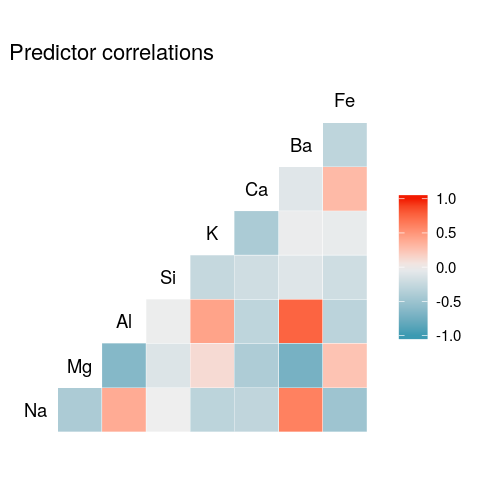

In [26]:
GGally::ggcorr(cor_mat) + ggtitle("Predictor correlations")

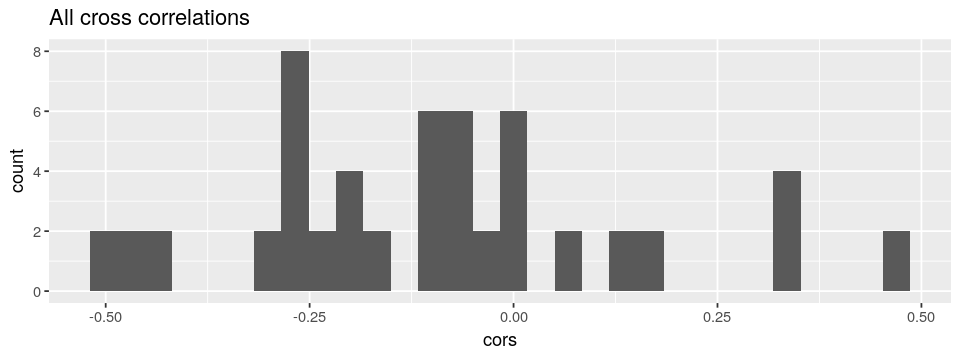

In [18]:
cors_dist_df <- data.frame(cors=as.vector(cor_mat)) %>% filter(cors != 1)
vu$pltsize(8, 3)
ggplot(cors_dist_df, aes(cors)) + geom_histogram(bins=30) + ggtitle("All cross correlations")

In [28]:
head(wide_stones_df)

nr,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


In [27]:
head(long_stones_df)

key,value
Na,13.64
Na,13.89
Na,13.53
Na,13.21
Na,13.27
Na,12.79


In [37]:
pairwise_comp <- function(df, sample1, sample2) {
    ggplot(df, aes_string(x=df[, sample1], y=df[, sample2])) + 
        geom_point() +
        ggtitle(paste(sample1, "vs", sample2)) +
        geom_smooth(method="lm", formula=y~x) +
        xlab(sample1) +
        ylab(sample2)
}

In [39]:
plotmatrix(as.data.frame(wide_stones_df), "Na", "Mg")

ERROR: Error in plotmatrix(as.data.frame(wide_stones_df), "Na", "Mg"): could not find function "plotmatrix"


In [59]:
head(long_stones_df)

key,value
Na,13.64
Na,13.89
Na,13.53
Na,13.21
Na,13.27
Na,12.79


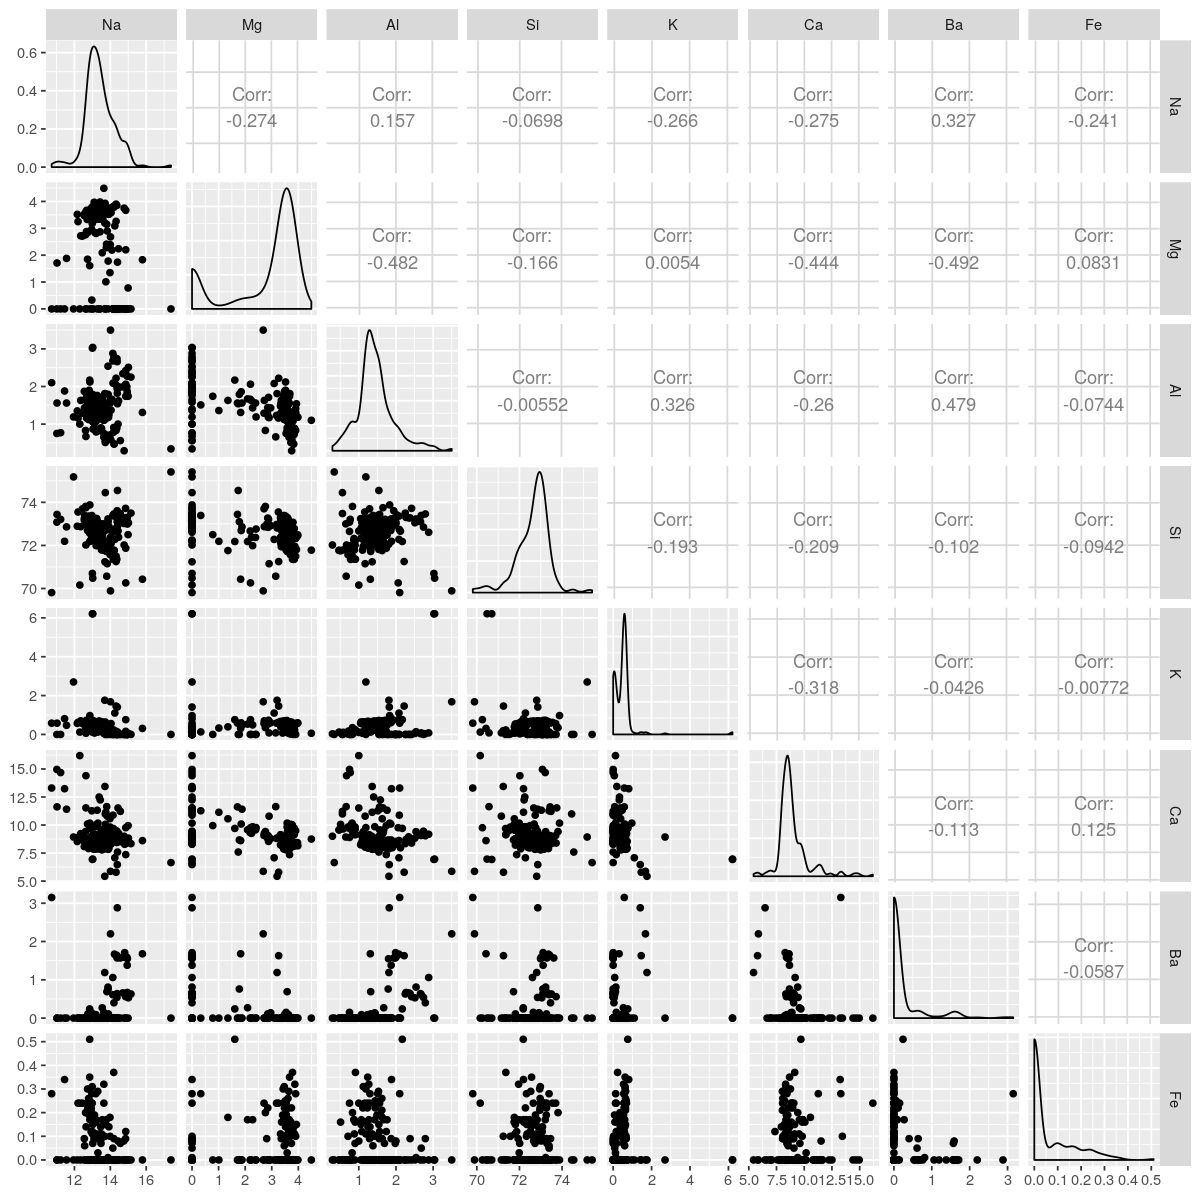

In [85]:
vu$pltsize(10, 10)
GGally::ggpairs(wide_stones_df[, stone_cols])

In [86]:
# pltlist <- list()
# plt_index <- 1
# for (outer_index in seq_len(length(stone_cols)-1)) {
#     for (inner_index in seq(outer_index+1, length(stone_cols))) {
#         corr1 <- stone_cols[outer_index]
#         corr2 <- stone_cols[inner_index]
# #         message("outer", corr1, "inner", corr2)
        
#         pltlist[[plt_index]] <- pairwise_comp(as.data.frame(wide_stones_df), corr1, corr2)        
#         plt_index <- plt_index + 1
#     }
# }

# vu$pltsize(12, 12)
# vu$multiplot(plotlist=pltlist, cols=8)

# # pairwise_comp(as.data.frame(wide_stones_df), "Na", "Mg")

# Training

Start with using all variables as continuous. Try a general regression. Also try a logistic model.

In [116]:
head(wide_stones_df)

nr,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


In [131]:
control <- caret::trainControl(
    method="repeatedcv",
    number=10,
    repeats=3
)

models <- list()
# methods <- c("lm", "")

models[["linear"]] <- caret::train(
    Type~.,
    data=wide_stones_df %>% dplyr::select(-nr),
    method="lm",
    preProcess="scale",
    trControl=control
)

models[["randfor"]] <- caret::train(
    Type~.,
    data=wide_stones_df %>% dplyr::select(-nr),
    method="ranger",
    preProcess="scale",
    trControl=control
)

In [133]:
for (model in models) {
    print(model)
}

Linear Regression 

214 samples
  9 predictors

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 193, 193, 193, 192, 193, 192, ... 
Resampling results:

  RMSE      Rsquared   MAE      
  1.129318  0.7179799  0.8111239

Tuning parameter 'intercept' was held constant at a value of TRUE
Random Forest 

214 samples
  9 predictors

Pre-processing: scaled (9) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 192, 191, 193, 193, 193, 194, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE       Rsquared   MAE      
  2     variance    0.9502948  0.7989423  0.6428505
  2     extratrees  0.9363320  0.8113923  0.6700831
  5     variance    0.9414580  0.7960233  0.6018793
  5     extratrees  0.9241132  0.8083243  0.6293030
  9     variance    0.9603731  0.7839069  0.5937056
  9     extratrees  0.9128458  0.8090213  0.6042285

Tuning parameter 'min.node.size' was held constant at

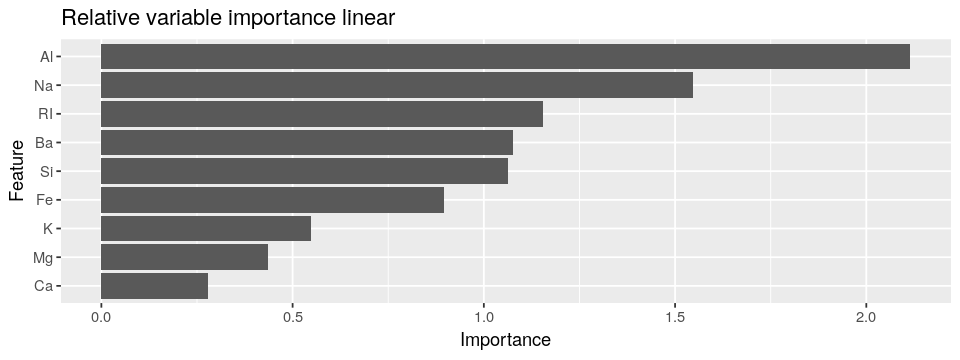

In [139]:

for (model_name in "linear") {
    model <- models[[model_name]]
#     print(model)
    importance <- caret::varImp(model, scale=FALSE, threshold=10)
    # print(importance)
    vu$pltsize(8, 3)
    plt <- ggplot(importance) + ggtitle(paste("Relative variable importance", model_name))
    print(plt)
}



# Recursive feature selection

In [140]:
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
results <- rfe(
    Type~.,
    data=wide_stones_df %>% dplyr::select(-nr),
    sizes=1:nrow(wide_stones_df),
    rfeControl=control
)

In [141]:
head(results$variables)

Overall,var,Variables,Resample
32.74598,Mg,9,Fold01
20.08889,RI,9,Fold01
15.87244,Ba,9,Fold01
15.81187,Al,9,Fold01
15.28305,Na,9,Fold01
15.15894,Ca,9,Fold01


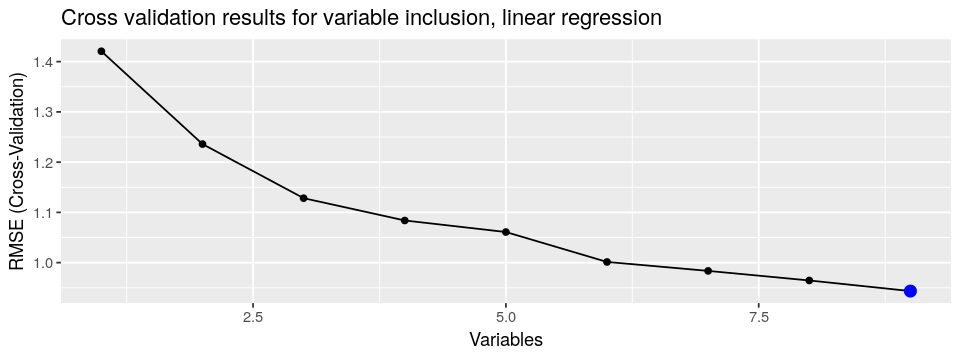

In [143]:
pred_subset <- predictors(results)
ggplot(results) + ggtitle("Cross validation results for variable inclusion, linear regression")